In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import time

def to3D(site,L):
    z = site//(L*L)
    sitexy = site - (z*L*L)
    y = sitexy%L
    x = sitexy//L
    return z,x,y

def init(N,L):
    """returns a list of N occupied sites and an LxL lattice with 0's for
       empty sites and integers >0 corresponding to non-empty sites. """
    lattice = numpy.zeros((L,L,L),dtype=numpy.int8)#Initialize empty lattice
    occupied = numpy.random.choice(L*L*L,N,replace=False)
    for i,site in enumerate(occupied):
        z,x,y = to3D(site,L) # this finds the z,y,x coordinate of the site wrt the site number
        lattice[z][x][y] = i+1 # this find the site we are talking about, find its x,y,z and put a 1 in the corresponding place
    return occupied, lattice
        
def adjacent(site,L):
    """Return a tuple with indices corresponding to the four sites adjacent
       to the one passed in, wrapping around a LxL periodic volume."""
    z,x,y = to3D(site,L) # this finds the z,y,x coordinate of the site wrt the site number
    
    zscale = z*L*L
    xyscale = site - zscale
    
    left = ((y - 1 + L) % L) + (x*L) + zscale
    right = ((y + 1) % L) + (x*L) + zscale
    up =  ((x - 1 + L) % L)*L + y + zscale
    down =  ((x + 1) % L)*L + y + zscale
    front = ((z + L + 1) % L)*L*L + xyscale
    back =  ((z + L - 1 ) % L)*L*L + xyscale
    return (right, down, front, left, up , back)
    
def energy(occupied,lattice,epsilon=-1):
    """Returns the total potential energy for the occupied sites on a lattice."""
    U = 0
    L = len(lattice)
    for site in occupied: #loop over all sites
        for neighbor in adjacent(site,L)[:3]: #Look right,down, front to avoid double counting
            z,x,y = to3D(neighbor,L) # this finds the z,y,x coordinate of the site wrt the site number
            if lattice[neighbor//(L*L)][(neighbor-(z*L*L))//L][(neighbor-(z*L*L))%L] != 0:
                U+=epsilon
                
    return U

def trial_move(occupied,lattice,T):
    L=len(lattice)
    V = L*L*L
    Uo = energy(occupied,lattice)
    numpy.random.shuffle(occupied) #shuffles the elements of occupied
    old = occupied[0]
    empty_mask = numpy.isin(numpy.arange(V),occupied,invert=True)
    empty_sites = numpy.arange(V)[empty_mask] # list of empty sites
    new = empty_sites[numpy.random.randint(len(empty_sites))]
    occupied[0]= new
    zn,xn,yn = to3D(new,L)
    zo,xo,yo = to3D(old,L)
    lattice[zn][xn][yn] = lattice[zo][xo][yo]
    lattice[zo][xo][yo] = 0
    Un = energy(occupied,lattice)
    if (Un<=Uo) or numpy.random.random() < numpy.exp(-(Un-Uo)/T):
        return occupied, lattice, Un
    lattice[zo][xo][yo] = lattice[zn][xn][yn]
    lattice[zn][xn][yn] = 0
    occupied[0]=old
    return occupied, lattice, Uo

def run(nsteps,T,occupied, lattice):
    U = []
    for step in range(int(nsteps)):
        occupied, lattice, u = trial_move(occupied, lattice,T)
        U.append(u)
    return numpy.array(U)/len(occupied)

def analyze(data):
    a = numpy.average(data)
    s = numpy.std(data)
    return a,s

In [69]:
Temps = numpy.linspace(0.1,1.3,num=len(times)) # Interesting range of temperatures to control movement of N particles MAKE THIS LEN=LEN(TIME)
Length = range(2,18,1) # Sets our N values with (start,stop,resolution)
results = {}
for L in Length: # Every 1 length change, print results to look at
    onerun = []
    print(L)
    for T in Temps:
        print("\t",T)
        occupied, lattice = init((L*L*L)//4,L) # N to be a quater of the volume always. Fixed density, L
        start = time.time()
        U = run(1e3,T,occupied, lattice)
        a, s = analyze(U)
        finish = time.time()
        onerun.append((a,s,finish-start))
        results[L] =  numpy.array(onerun)

2
	 0.1
	 0.17058823529411765
	 0.2411764705882353
	 0.31176470588235294
	 0.38235294117647056
	 0.4529411764705882
	 0.5235294117647059
	 0.5941176470588235
	 0.6647058823529411
	 0.7352941176470588
	 0.8058823529411764
	 0.8764705882352941
	 0.9470588235294117
	 1.0176470588235293
	 1.0882352941176472
	 1.1588235294117648
	 1.2294117647058824
	 1.3
3
	 0.1
	 0.17058823529411765
	 0.2411764705882353
	 0.31176470588235294
	 0.38235294117647056
	 0.4529411764705882
	 0.5235294117647059
	 0.5941176470588235
	 0.6647058823529411
	 0.7352941176470588
	 0.8058823529411764
	 0.8764705882352941
	 0.9470588235294117
	 1.0176470588235293
	 1.0882352941176472
	 1.1588235294117648
	 1.2294117647058824
	 1.3
4
	 0.1
	 0.17058823529411765
	 0.2411764705882353
	 0.31176470588235294
	 0.38235294117647056
	 0.4529411764705882
	 0.5235294117647059
	 0.5941176470588235
	 0.6647058823529411
	 0.7352941176470588
	 0.8058823529411764
	 0.8764705882352941
	 0.9470588235294117
	 1.0176470588235293
	 1.088235

Text(0.5, 1.0, 'Time to Complete Simulation compared to V from L^3 at density = 1/4')

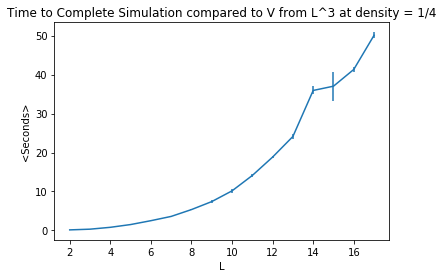

In [71]:
times = []
for L in Length:
    times.append((numpy.average(results[L][:,2]),numpy.std(results[L][:,2])))
times = numpy.array(times)
plt.errorbar(Length,times[:,0],times[:,1])
plt.xlabel("L")
plt.ylabel("<Seconds>")
plt.title('Time to Complete Simulation compared to V from L^3 at density = 1/4')


0.21426070671803008
0.18710547754876675
0.17398962964754272
0.14077340844238231
0.10877923536790048
0.0725599431719905
the standard deviation falls with increasing L


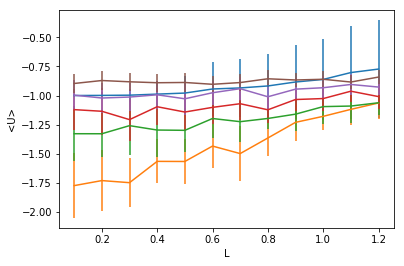

In [40]:
plt.errorbar(Length,results[2][:,0],results[2][:,1])
plt.errorbar(Length,results[5][:,0],results[5][:,1])
plt.errorbar(Length,results[9][:,0],results[9][:,1])
plt.errorbar(Length,results[11][:,0],results[11][:,1])
plt.errorbar(Length,results[14][:,0],results[14][:,1])
plt.errorbar(Length,results[18][:,0],results[18][:,1])
plt.xlabel("L")
plt.ylabel("<U>")
print(numpy.mean(results[2][:,1]))
print(numpy.mean(results[5][:,1]))
print(numpy.mean(results[9][:,1]))
print(numpy.mean(results[11][:,1]))
print(numpy.mean(results[14][:,1]))
print(numpy.mean(results[18][:,1]))
print("the standard deviation falls with increasing L")